In [3]:
#%% Add to path
import sys
%cd ..

with open('python_paths.txt', 'r') as f:
    paths = f.read().splitlines()
for path in paths:
    if path not in sys.path:
        sys.path.append(path)

        
print(sys.path)
print(sys.executable)


/media/theodore/HDD1/These/projets/semisup
['/media/theodore/HDD1/These/projets/semisup/Notebooks', '/usr/lib/python37.zip', '/usr/lib/python3.7', '/usr/lib/python3.7/lib-dynload', '', '/media/theodore/HDD1/Spondi/SpondiDetect/venv/lib/python3.7/site-packages', '/media/theodore/HDD1/Spondi/SpondiDetect/venv/lib/python3.7/site-packages/SimpleITK-1.2.0rc2.dev1162+g2a79d-py3.7-linux-x86_64.egg', '/media/theodore/HDD1/Spondi/SpondiDetect/venv/lib/python3.7/site-packages/IPython/extensions', '/home/theodore/.ipython', '/home/aouadt/SpondiDetect/SpondiDetect', './', '/media/theodore/HDD1/Spondi/SpondiDetect']
/media/theodore/HDD1/Spondi/SpondiDetect/venv/bin/python3


In [54]:
#%% Reload modules
from importlib import reload
import random

import numpy as np
import matplotlib.pyplot as plt

def reload_modules():
    for mudl in []:
        reload(mudl)
        
reload_modules()

# 2d

In [52]:
n = 1000
yoff = 2

def f1(xs, yoff=yoff):
    return np.cos(7*xs) - yoff / 2 + np.random.rand(len(xs))

def f2(xs, yoff=yoff):
    return np.cos(7*xs) + yoff / 2 + np.random.rand(len(xs))

xs1 = np.linspace(0, 1, n) + np.random.rand(n)
xs2 = np.linspace(0, 1, n) + np.random.rand(n)

xs = np.concatenate([xs1, xs2])  # First coordinate
ys = np.concatenate([f1(xs1), f2(xs2)])  # Second coordinate
cs = np.concatenate([np.zeros(n), np.ones(n)])  # Class

In [72]:
nlabels = 30
lab = random.sample(range(len(xs)), nlabels)
unlab = list(set(np.arange(len(xs))).difference(labelized))

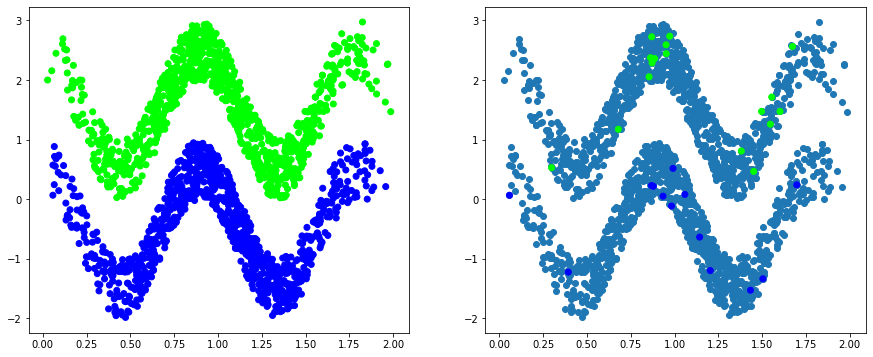

In [73]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))
axs[0].scatter(xs, ys, c=cs, cmap='brg')
axs[1].scatter(xs[unlab], ys[unlab])
axs[1].scatter(xs[lab], ys[lab], c=cs[lab], cmap='brg') 
